# Predict Leaf Disease Notebook

This notebook runs the Python script to predict leaf diseases using a trained model.

In [65]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pickle
import logging
import zipfile
import os

## Setup Logging

In [66]:
logger = logging.getLogger(__name__)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

MODEL_FILENAME = "trained_model.h5"
CLASSES_FILENAME = "classes.pkl"

## Load Model From Zip

In [67]:
def load_model_from_zip(zip_path, model_filename):
    """
    Extracts the .h5 file from the zip, loads it with Keras, then returns the model.
    """
    with zipfile.ZipFile(zip_path, 'r') as zf:
        model_basename = os.path.basename(model_filename)
        zf.extract(model_basename, path='.')
    model = tf.keras.models.load_model(model_basename)
    return model

## Predict Image

In [68]:
def predict_image(model: tf.keras.Model, img_path: str) -> tuple[int, float]:
    """ Predict the class of an image using the trained model """
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)
    class_idx = np.argmax(preds[0])
    confidence = preds[0][class_idx]
    return class_idx, confidence


## Unzip

In [69]:
def unzip(zip_path: str) -> tuple[tf.keras.Model, list[str]]:
    """ Unzips the archive and loads the model and classes """
    if not zipfile.is_zipfile(zip_path):
        logger.error(f"Error: {zip_path} is not a valid zip file.")
        raise zipfile.BadZipFile(f"{zip_path} is not a valid zip file.")

    with zipfile.ZipFile(zip_path, 'r') as zf:
        try:
            zf.extract(MODEL_FILENAME, path=".")
            zf.extract(CLASSES_FILENAME, path=".")
        except KeyError as e:
            logger.error(f"Error: {e} not found in {zip_path}.")
            raise

    model = tf.keras.models.load_model(MODEL_FILENAME)
    with open(CLASSES_FILENAME, 'rb') as f:
        classes = pickle.load(f)
    return model, classes

## Plot Results

In [70]:
def plot_results(img_path: str, confidence: float, predicted: str, save: bool):
    """ Plot the original and resized images with predictions """
    img = image.load_img(img_path)

    plt.figure(num='Prediction')
    plt.imshow(img)
    plt.text(
        img.width / 2,
        img.height - 10,
        f"Pred: {predicted}\nConf: {confidence:.2f}",
        fontsize=12,
        ha='center',
        va='center',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='black')
    )
    plt.title(f"Image: {img_path}")
    plt.tight_layout()
    plt.axis('off')
    if save:
        plt.savefig(f"prediction_{os.path.basename(img_path)}")
    plt.show()

## Extract Images

In [71]:
def extract_images(image_path: str, dir_path: str) -> list[str]:
    """ Extract images from the specified path """
    if image_path:
        return [image_path]

    images = []
    for root, _, files in os.walk(dir_path):
        for file in files:
            if file.lower().endswith('jpg'):
                images.append(os.path.join(root, file))
    return images


## Main Function

In [74]:
def main():
    """Main function for notebook prediction using a single zip file."""
    image_path = '/content/image (1)_scab.JPG'
    tmz = '/content/trained_model_and_augmented.zip'

    if not os.path.isfile(image_path):
        print(f'Error: {image_path} is not a valid file.')
        return
    if not os.path.isfile(tmz):
        print(f'Error: {tmz} does not exist.')
        return

    model, classes = unzip(tmz)
    print('Model loaded successfully.')

    class_idx, confidence = predict_image(model, image_path)
    predicted_class = classes[class_idx] if class_idx < len(classes) else 'Unknown'

    img_original = image.load_img(image_path)
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(img_original)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    resized_img = image.load_img(image_path, target_size=(224, 224))
    axes[1].imshow(resized_img)
    axes[1].set_title(f'Transformed (Resized)\nPred: {predicted_class}\nConf: {confidence:.2f}')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

## Run Main

Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


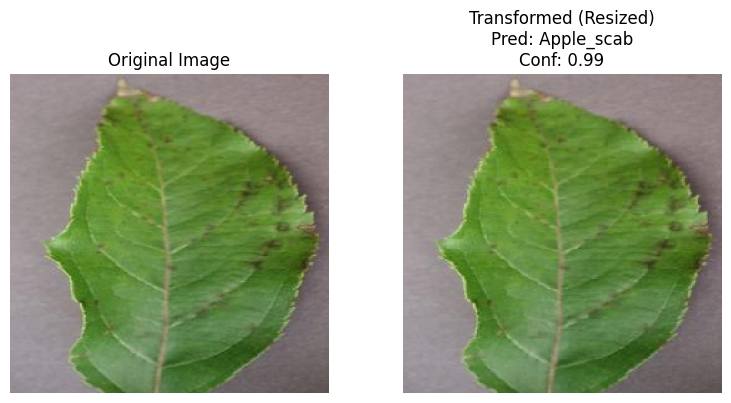

In [75]:
main()